# Rapport: Förutsägelse av Hjärt- och Kärlsjukdomar med Maskininlärning


## Introduktion och problemställning
Denna rapport syftar till att undersöka och analysera kliniska och demografiska data för att utveckla en prediktiv modell för hjärt- och kärlsjukdomar. Genom att tillämpa maskininlärningstekniker på data från Kaggle, strävar studien efter att identifiera de mest signifikanta faktorerna som bidrar till risken för dessa sjukdomar.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

data_path = "data/cardio_train.csv"
data = pd.read_csv(data_path, sep=";")

# Data-analys (EDA)

### Datasetets sammansättning
Datasetet innehåller initialt 70 000 observationer som, efter rensning från outliers och orimliga värden, minskades till 67 893. Analyser visar en jämn fördelning mellan diagnoserade fall och icke-fall av hjärt-kärlsjukdom, med en medelålder på cirka 53 år bland deltagarna.

Betydande insikter inkluderar:

- Majoriteten av patienterna har normala kolesterolvärden.
- Rökning förekommer hos 8.86% av patienterna.
- En analys av kroppsmasseindex (BMI) och blodtryck visar en varierande riskfördelning för hjärt-kärlsjukdom.

Särskilt adresserades outliers såsom extremt låga eller höga längder jämfört med befolkningsnormer och osannolika värden för systoliskt och diastoliskt blodtryck, vilka antogs vara inskrivningsfel. 

- Sjukdomsförekomst: Av de 67,893 patienterna i datamängden är 33,540 (cirka 49.41%) diagnostiserade med hjärt-kärlsjukdom medan 34,353 (cirka 50.59%) inte har någon sådan diagnos. Detta indikerar en nästan jämn fördelning mellan positiva och negativa fall av hjärt-kärlsjukdom.
- Kolesterolnivåer: Majoriteten av patienterna, 75.04%, har normala kolesterolvärden. Cirka 13.53% har värden över det normala, och 11.43% har värden som är mycket över det normala.
- Åldersfördelning: Medelåldern bland patienterna är cirka 53 år, med en standardavvikelse på cirka 6.76 år. Åldersspannet sträcker sig från 39 till 65 år.
- Rökande: Cirka 8.86% av patienterna i datamängden är rökare.
- Viktfördelning: Medelvikten är cirka 74.12 kg med en standardavvikelse på 13.92 kg. Viktspannet från 40 till 140 kg.
- Längdfördelning: Medellängden är cirka 164.61 cm, med en standardavvikelse på cirka 7.62 cm. Längdvariationen från 147 cm till 207 cm.
- Sjukdomsförekomst per kön: Andelen kvinnor med hjärt-kärlsjukdom är nästan lika stor som andelen män, med 49.10% för kvinnor och 49.95% för män. Detta antyder att risken för hjärt-kärlsjukdomar är likartad över könen inom den studerade populationen.

In [3]:
# Omvandlar ålder och avrunda till närmaste heltal
data['age_years'] = (data['age'] / 365.25).round()

# Filtrerar bort extrema och omöjliga värden
filtered_data = data[
    (data['height'] <= 220) & 
    (data['height'] >= 147) & 
    (data['ap_hi'] <= 250) &
    (data['ap_hi'] >= 40) &
    (data['ap_lo'] <= 200) &
    (data['ap_lo'] >= 40) &
    (data['ap_lo'] < data['ap_hi']) &
    (data['weight'] >= 40) & 
    (data['weight'] <= 140) &
    (data['age_years'] >= 39)].copy()

# Tar bort kolumnerna 'age' och 'id'
filtered_data.drop(columns=['age', 'id'], inplace=True)

# EDA-frågor
eda_results = {
    'positiva_för_sjukdom': filtered_data['cardio'].sum(),
    'negativa_för_sjukdom': len(filtered_data) - filtered_data['cardio'].sum(),
    'cholesterol_fördelning': filtered_data['cholesterol'].value_counts(normalize=True) * 100,
    'åldersfördelning': filtered_data['age_years'].describe(),
    'röker_andel': filtered_data['smoke'].mean() * 100,
    'viktfördelning': filtered_data['weight'].describe(),
    'längdfördelning': filtered_data['height'].describe(),
    'sjukdom_kön_fördelning': filtered_data.groupby('gender')['cardio'].mean() * 100}

In [4]:
# Delar upp kolumnerna i två listor
boxplot_columns = ['weight', 'height', 'ap_hi', 'ap_lo', 'age_years'] # Kontinuerliga variabler
barplot_columns = ['cholesterol', 'gluc', 'gender', 'smoke', 'alco', 'active', 'cardio'] # Kategoriska variabler

# Mappar för svenska namn och enheter
column_names_map = {
    'weight': 'Vikt (kg)',
    'height': 'Längd (cm)',
    'ap_hi': 'Systoliskt blodtryck(mm Hg)',
    'ap_lo': 'Diastoliskt blodtryck(mm Hg)',
    'age_years': 'Ålder i år',
    'cholesterol': 'Kolesterol',
    'gluc': 'Glukos',
    'gender': 'Kön',
    'smoke': 'Rökare',
    'alco': 'Alkohol',
    'active': 'Aktiv',
    'cardio': 'Hjärt-kärlsjukdom'}

### Visualiseringar genom boxplots och barplots gav ytterligare insikter i distributionen av variabler såsom vikt, längd och blodtryck.

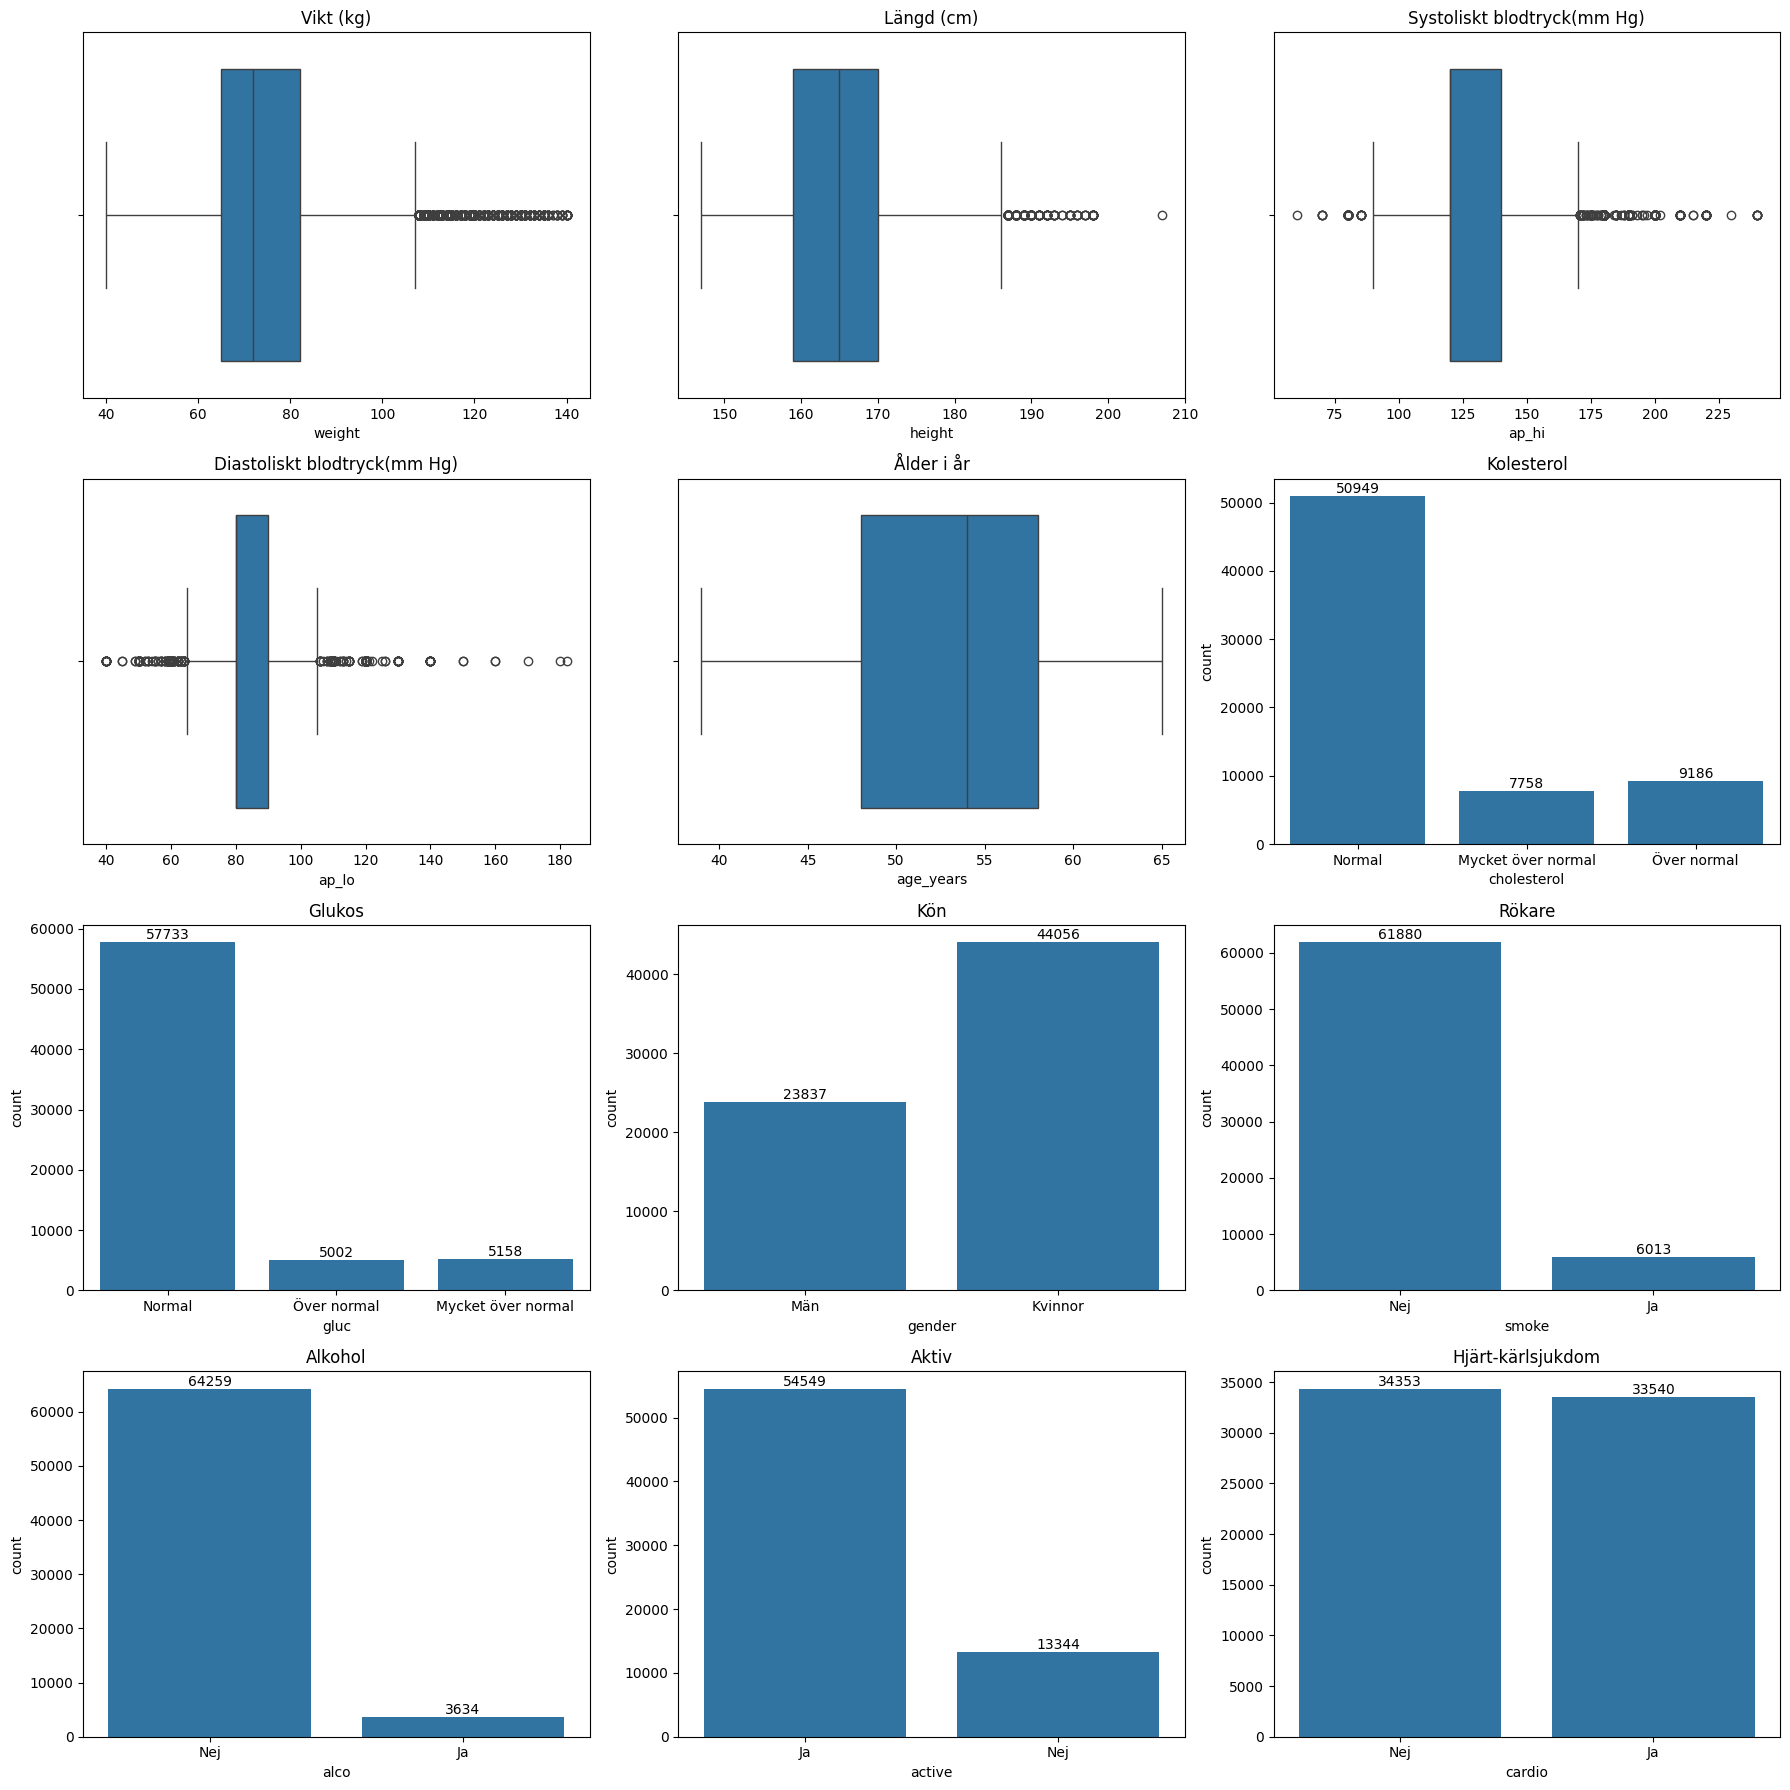

In [5]:
# Anger figurstorleken
plt.figure(figsize=(18, 18))

# Loopar genom boxplot_columns för att skapa boxplots
for i, col in enumerate(['weight', 'height', 'ap_hi', 'ap_lo', 'age_years'], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=filtered_data[col])
    plt.title(column_names_map[col])

# Loopar genom barplot_columns för att skapa barplots och lägga till antalet människor samt svenska ord
for i, col in enumerate(['cholesterol', 'gluc', 'gender', 'smoke', 'alco', 'active', 'cardio'], 1):
    ax = plt.subplot(4, 3, i + len(boxplot_columns))  # Fortsätt layouten där boxplots slutade
    if col == 'gender':
        sns.countplot(x=filtered_data[col].map({1: 'Kvinnor', 2: 'Män'}))
    elif col in ['cholesterol', 'gluc']:
        sns.countplot(x=filtered_data[col].map({1: 'Normal', 2: 'Över normal', 3: 'Mycket över normal'}))
    elif col in ['smoke', 'alco', 'active', 'cardio']:
        sns.countplot(x=filtered_data[col].map({0: 'Nej', 1: 'Ja'}))
    plt.title(column_names_map[col])

    # Använder containerobjekt för att iterera över bars
    for container in ax.containers:
        ax.bar_label(container)

plt.tight_layout()
plt.show()

# Feature Engineering
Flera features utvecklades baserat på befintlig data:

BMI (Body Mass Index): Kategoriserades i olika grupper från 'Undervikt' till 'Fetma (Klass III)', vilket gav viktiga insikter i sambandet mellan kroppsvikt och risk för hjärt- och kärlsjukdomar.
BMI filtreras även baserat på vanligtvis accepterade gränser för BMI (10 till 50)

Blodtryckskategorier: Definierades enligt WHO:s riktlinjer för att ytterligare förstå sambandet mellan blodtrycksnivåer och sjukdomsrisk.

Systoliskt och diastoliskt blodtryck ratio: Förhållande mellan ap_hi och ap_lo

Kombination av rökning och alkoholkonsumtion: summering av värdena för dessa två variabler. Både rökning och alkoholkonsumtion är binära variabler där 1 representerar en rökare/drickare och 0 representerar en icke-rökare/icke-drickare. Ger insikt i hur kombinationen av dessa två vanor påverkar risken för hjärt-kärlsjukdom.

In [6]:
# Tar först bort alla befintliga 'BMI_' och 'BP_' kolumner för att slippa dubletter
for col in filtered_data.columns:
    if col.startswith('BMI_') or col.startswith('BP_'):
        filtered_data.drop(col, axis=1, inplace=True)
        
# Skapar en kategorisk feature för BMI baserat på vanligt accepterade kategorier
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Undervikt'
    elif bmi <= 24.9:
        return 'Normalvikt'
    elif bmi <= 29.9:
        return 'Övervikt'
    elif bmi <= 34.9:
        return 'Fetma (Klass I)'
    elif bmi <= 39.9:
        return 'Fetma (Klass II)'
    else:
        return 'Fetma (Klass III)'

# Definierar en funktion för att kategorisera blodtryck
def categorize_blood_pressure(ap_hi, ap_lo):
    if ap_hi < 120 and ap_lo < 80:
        return 'Optimalt'
    elif 120 <= ap_hi <= 129 or 80 <= ap_lo <= 84:
        return 'Normalt'
    elif 130 <= ap_hi <= 139 or 85 <= ap_lo <= 89:
        return 'Högt normalt'
    elif 140 <= ap_hi <= 159 or 90 <= ap_lo <= 99:
        return 'Hypertoni grad 1'
    elif 160 <= ap_hi <= 179 or 100 <= ap_lo <= 109:
        return 'Hypertoni grad 2'
    elif ap_hi >= 180 or ap_lo >= 110:
        return 'Hypertoni grad 3'
    elif ap_hi >= 140 and ap_lo < 90:
        return 'Isolerad systolisk hypertoni'
    else:
        return 'Okategoriserat'
    
# Beräknar BMI för varje individ i datasetet
filtered_data['BMI'] = filtered_data['weight'] / ((filtered_data['height'] / 100) ** 2)

# Filtrera datan med gränser för BMI
filtered_data = filtered_data[(filtered_data['BMI'] >= 10) & (filtered_data['BMI'] <= 50)]

# Skapar och tillämpar funktionen categorize_bmi och categorize_blood_pressure
filtered_data['BMI_category'] = filtered_data['BMI'].apply(categorize_bmi)
filtered_data['Blood_pressure_category'] = filtered_data.apply(
    lambda row: categorize_blood_pressure(row['ap_hi'], row['ap_lo']), axis=1
)
# Skapar feautures för blodtryck ratio och komination av alkohol + rökning
filtered_data['bp_ratio'] = filtered_data['ap_hi'] / filtered_data['ap_lo']
filtered_data['smoke_alco'] = filtered_data['smoke'] + filtered_data['alco']

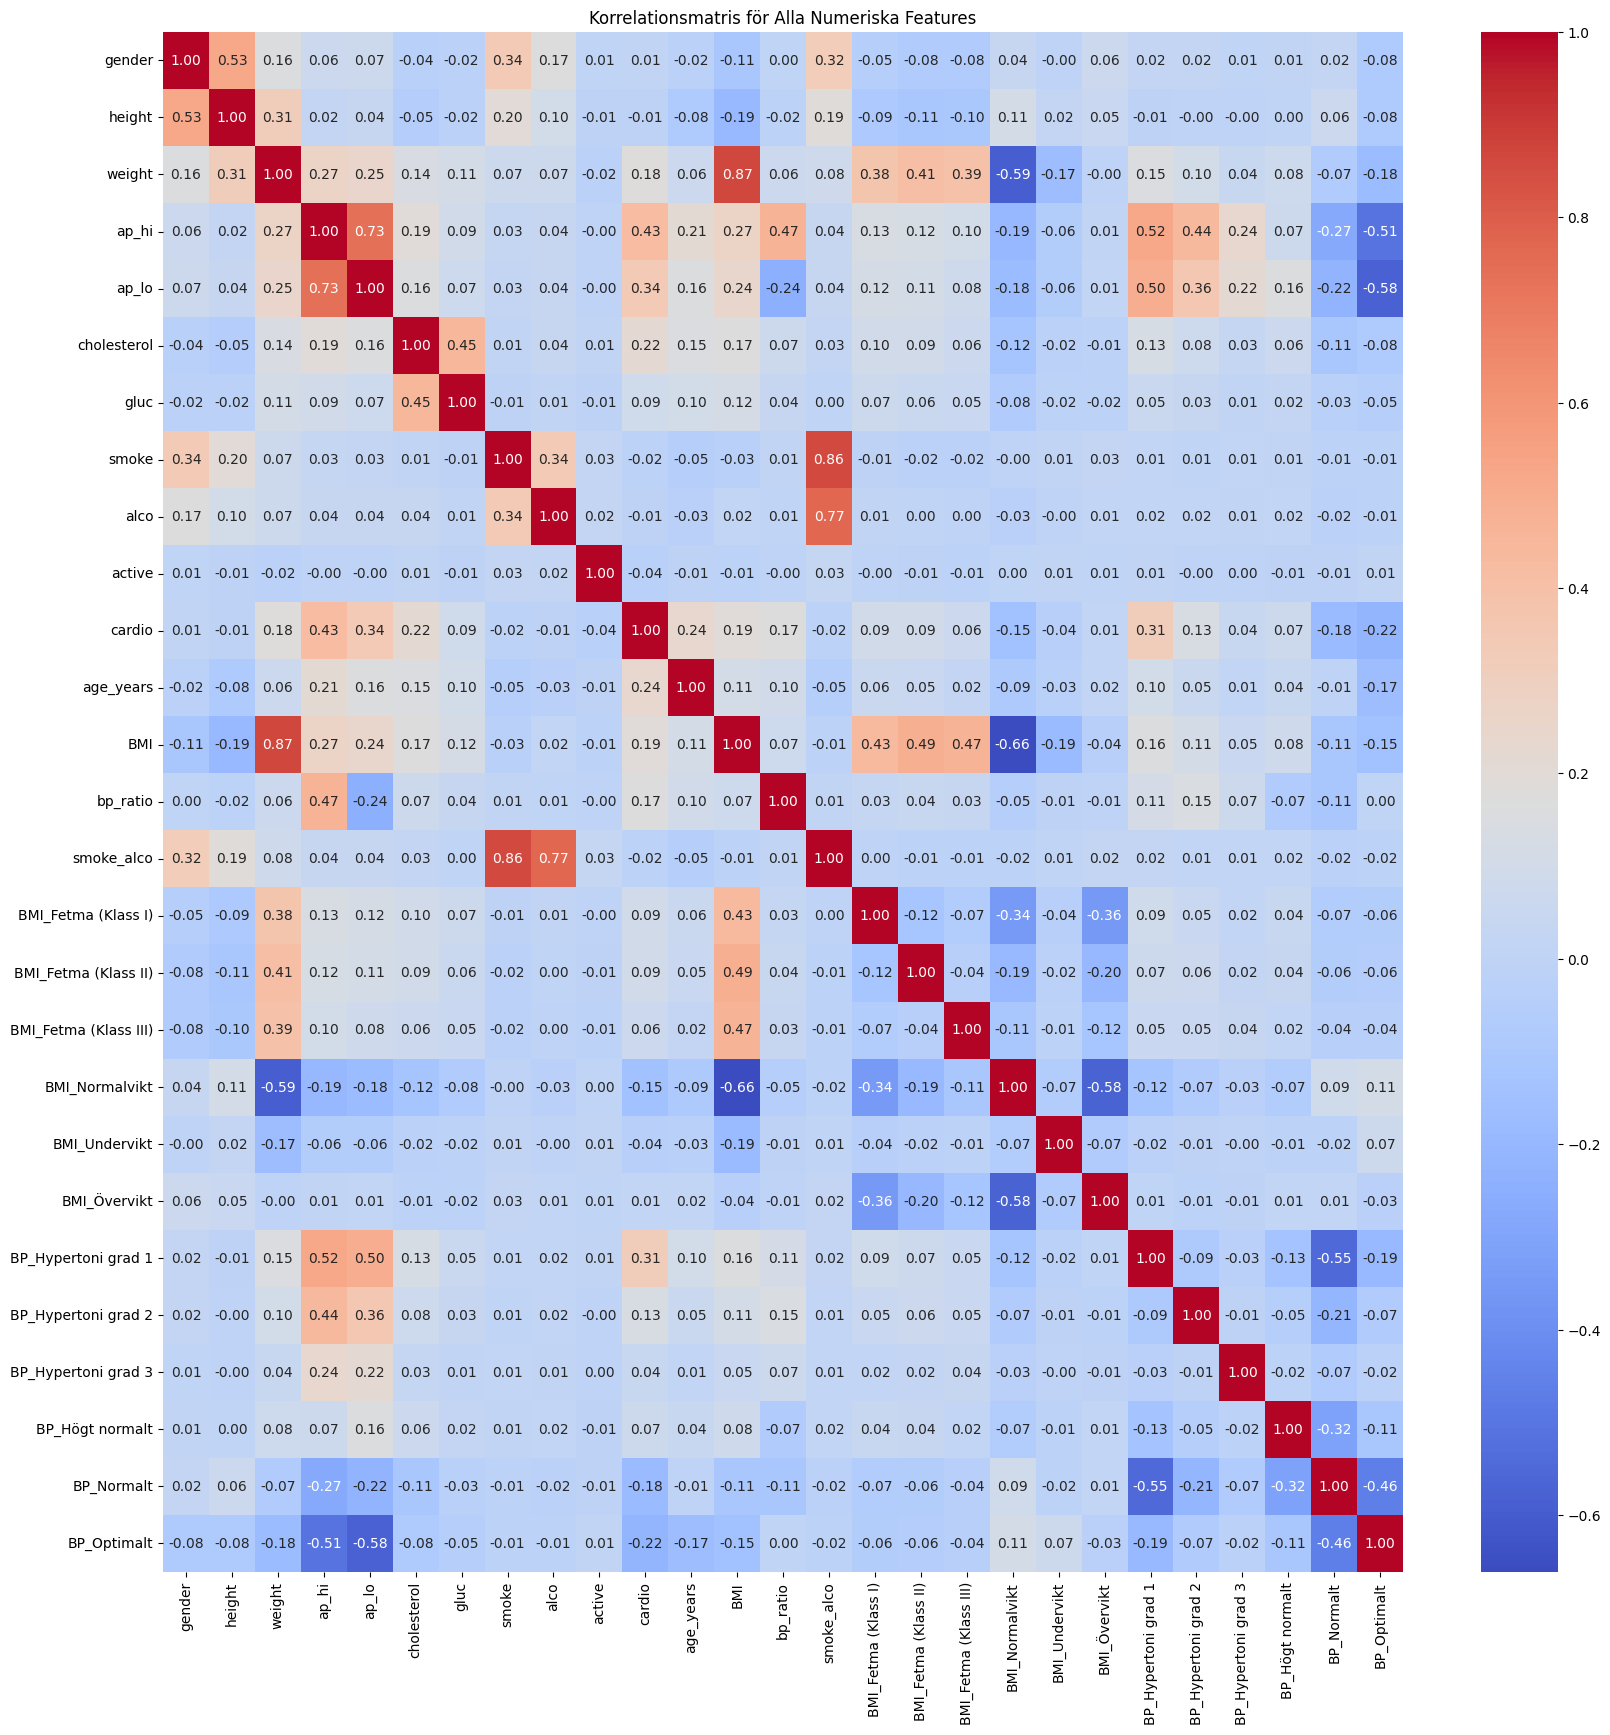

In [7]:
# Skapar dummy-variabler
bmi_dummies = pd.get_dummies(filtered_data['BMI_category'], prefix='BMI')
blood_pressure_dummies = pd.get_dummies(filtered_data['Blood_pressure_category'], prefix='BP')

filtered_data = pd.concat([filtered_data, bmi_dummies, blood_pressure_dummies], axis=1)
filtered_data.drop(columns=['BMI_category', 'Blood_pressure_category'], inplace=True)

# Beräknar korrelationsmatrisen
numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns
numeric_filtered_data = filtered_data[numeric_columns]
corr_matrix = numeric_filtered_data.corr()

# Extraherar korrelationen för BMI och blodtryckskategorier
bmi_corr = corr_matrix['BMI']
bp_columns = [col for col in filtered_data.columns if col.startswith('BP_') and not filtered_data[col].dtype == 'object']
blood_pressure_correlations = filtered_data[bp_columns].corr()

# Konverterar booleanska kolumner till integers
for col in filtered_data.columns:
    if filtered_data[col].dtype == 'bool':
        filtered_data[col] = filtered_data[col].astype(int)

# Beräknae korrelationsmatrisen
corr_matrix = filtered_data.corr()

# Skapar heatmap för korrelationsmatrisen
plt.figure(figsize=(20, 20))  # Storleken kan behöva justeras beroende på din skärmstorlek
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # Du kan växla till annot=True om du vill se korrelationskoefficienterna
plt.title('Korrelationsmatris för Alla Numeriska Features')
plt.xticks(rotation=90)  # Roterar x-axelns etiketter för läsbarhet
plt.yticks(rotation=0)   # Roterar y-axelns etiketter för läsbarhet
plt.show()

In [8]:
# Delar upp data i tränings- och testset
X = filtered_data.drop('cardio', axis=1)
y = filtered_data['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Skalar data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modell
- Beslutsträd och Random Forest: Dessa modeller presterade med lägre noggrannhet jämfört med logistisk regression, vilket pekar på styrkan hos enklare modeller för detta dataset.
- Logistisk Regression: Visade sig vara en väldigt effektiv modell med en noggrannhet på 72.4%, vilket understryker dess förmåga att korrekt klassificera risk för hjärt-kärlsjukdom.
- Support Vector Machines (SVM): Med en genomsnittlig noggrannhet på 73.14%
- Gradient Boosting Machines (GBM): Uppnådde en genomsnittlig noggrannhet på 73.56%

Både GBM och SVM indikterar på deras potential för förbättringar genom finjusteringar.

In [9]:
# Definiera parameterrummet som ska utforskas 
param_distribution = {
    'C': uniform(0.01, 10),
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Använder RandomizedSearchCV för att hitta de bästa hyperparametrarna
random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_distribution, n_iter=100, cv=5, scoring='accuracy', error_score='raise', random_state=42)
random_search.fit(X_train_scaled, y_train)

# Visar de bästa hyperparametrarna och den bästa noggrannheten
print("Bästa hyperparametrar:", random_search.best_params_)
print("Bästa korsvaliderade noggrannheten:", random_search.best_score_)

Bästa hyperparametrar: {'C': 3.7554011884736247, 'penalty': 'l2', 'solver': 'liblinear'}
Bästa korsvaliderade noggrannheten: 0.727844061177228


In [10]:
# Hyperparameteroptimering med GridSearchCV
parameters = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train_scaled, y_train)

# Utvärdering
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print("Bästa korsvaliderade noggrannhet:", grid_search.best_score_)
print("Bästa hyperparametrar:", grid_search.best_params_)
print(classification_report(y_test, y_pred))


Bästa korsvaliderade noggrannhet: 0.7279915317112781
Bästa hyperparametrar: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6867
           1       0.76      0.64      0.70      6697

    accuracy                           0.72     13564
   macro avg       0.73      0.72      0.72     13564
weighted avg       0.73      0.72      0.72     13564



In [11]:
# Plocka ut 100 slumpmässiga rader från datamängden
test_samples = filtered_data.sample(n=100, random_state=42)
test_samples.to_csv('test_samples.csv', index=False)

# Ta bort dessa 100 rader från den ursprungliga datamängden och träna modellen på resterande data
data_for_training = filtered_data.drop(test_samples.index)
X_full_train = data_for_training.drop('cardio', axis=1)
y_full_train = data_for_training['cardio']

# Skala om hela träningsdatamängden
scaler_full = StandardScaler()
X_full_train_scaled = scaler_full.fit_transform(X_full_train)

# Träna modellen på hela träningsdatamängden
full_model = LogisticRegression(C=1, solver='liblinear')
full_model.fit(X_full_train_scaled, y_full_train)

# Spara modellen och scaler till .pkl-filer
joblib.dump(full_model, 'gbm_model.pkl', compress=True)
joblib.dump(scaler_full, 'scaler.pkl', compress=True)

['scaler.pkl']

In [12]:
# Träna en beslutsträdsklassificerare
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_scaled, y_train)
dt_predictions = decision_tree_model.predict(X_test_scaled)
print("Beslutsträd Noggrannhet:", accuracy_score(y_test, dt_predictions))

Beslutsträd Noggrannhet: 0.6383072839870245


In [13]:
# Träna en Random Forest klassificerare
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_scaled, y_train)
rf_predictions = random_forest_model.predict(X_test_scaled)
print("Random Forest Noggrannhet:", accuracy_score(y_test, rf_predictions))

# Jämför med logistisk regression noggrannhet som redan beräknats
print("Logistisk Regression Noggrannhet:", accuracy_score(y_test, y_pred))

Random Forest Noggrannhet: 0.7008257151282807
Logistisk Regression Noggrannhet: 0.7246387496313772


In [14]:
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_scores = cross_val_score(gbm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Genomsnittlig noggrannhet för GBM:", gbm_scores.mean())

Genomsnittlig noggrannhet för GBM: 0.7356225266672527


In [15]:
svm_model = SVC(random_state=42)
svm_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Genomsnittlig noggrannhet för SVM:", svm_scores.mean())

Genomsnittlig noggrannhet för SVM: 0.7314383919254824


In [16]:
# Använder den bästa modellen för att göra förutsägelser på testdatan
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Utvärdering
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6867
           1       0.76      0.64      0.70      6697

    accuracy                           0.72     13564
   macro avg       0.73      0.72      0.72     13564
weighted avg       0.73      0.72      0.72     13564



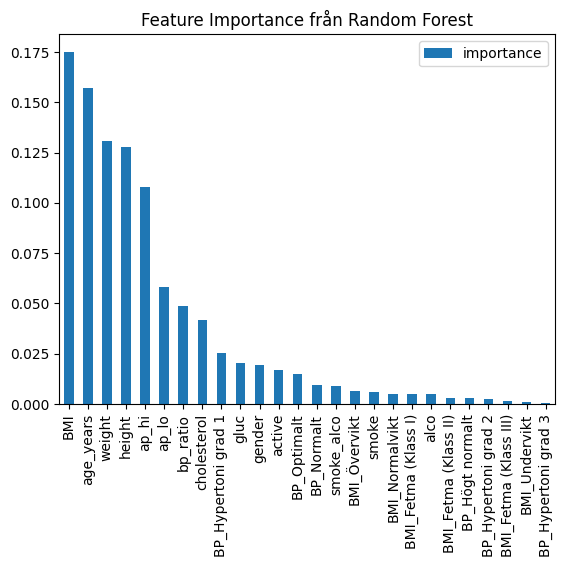

In [17]:
# Beräkna feature importance från Random Forest-modellen
feature_importances = pd.DataFrame(random_forest_model.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

# Visualisera feature importance
feature_importances.plot(kind='bar')
plt.title('Feature Importance från Random Forest')
plt.show()

# Resultat
### Den logistiska regressionsmodellen uppvisade en noggrannhet på ca 73% före tillägget av engineered feutures, vilket indikerar dess förmåga att effektivt klassificera risk för hjärt-kärlsjukdom. Resultaten presenterades genom en detaljerad utvärdering av modellens prestanda, inklusive precision, recall, och f1-score. En korrelationsmatris visualiserade även sambanden mellan de olika featuresna och målvariabeln, vilket stärker förståelsen för modellens beslut. Random Forest-modellens feature importance-analys betonar betydelsen av ålder, blodtryck och BMI som centrala prediktorer för hjärt-kärlsjukdom, vilket överensstämmer med medicinsk kunskap. Analysen visar att medan enklare modeller som logistisk regression presterar väl, kan mer avancerade algoritmer som GBM och SVM erbjuda ytterligare förbättringar i prediktionsförmågan. Det är dock viktigt att balansera modellkomplexiteten med tolkningsbarheten, särskilt inom medicinska tillämpningar.

### Denna studie understryker potentialen och vikten av att använda maskininlärning för att förbättra förståelsen och prediktionen av hjärt- och kärlsjukdomar. Genom att noggrant välja och kalibrera lämpliga modeller kan signifikanta framsteg göras mot tidig upptäckt och förebyggande av dessa tillstånd.

### Sannolikheter: Varje rad i output representerar en observation (i detta fall ett patientfall) från testdatasetet. Kolumnerna probability class 0 och probability class 1 visar modellens sannolikhetsuppskattning för att patienten inte har respektive har hjärt-kärlsjukdom.
### Förutsägelse: Kolumnen prediction visar modellens slutliga förutsägelse baserat på de beräknade sannolikheterna, där 0 indikerar ingen hjärt-kärlsjukdom och 1 indikerar förekomst av sjukdomen.